### Pseudomonas

In [ ]:
import pandas as pd
mic = pd.read_csv("drive/MyDrive/amr_pseudomonas.csv")
genome = pd.read_csv("drive/MyDrive/genome_pseudomonas.csv")
spg = pd.read_csv("drive/MyDrive/sp_gene_pseudomonas.csv")
print("----------------------")
print(mic.columns)
print("----------------------")
print(spg.columns)
print("----------------------")


<ipython-input-27-01f2a86dde2c>:3: DtypeWarning: Columns (4,5,13,14,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  genome = pd.read_csv("drive/MyDrive/genome_pseudomonas.csv")


----------------------
Index(['Taxon ID', 'Genome ID', 'Genome Name', 'Antibiotic',
       'Resistant Phenotype', 'Measurement', 'Measurement Sign',
       'Measurement Value', 'Measurement Unit', 'Laboratory Typing Method',
       'Laboratory Typing Method Version', 'Laboratory Typing Platform',
       'Vendor', 'Testing Standard', 'Testing Standard Year',
       'Computational Method', 'Computational Method Version',
       'Computational Method Performance', 'Evidence', 'Source', 'PubMed'],
      dtype='object')
----------------------
Index(['Evidence', 'Property', 'Source', 'Genome Name', 'BRC ID',
       'RefSeq Locus Tag', 'Alt Locus Tag', 'Source ID', 'Source Organism',
       'Gene', 'Product', 'Function', 'Classification', 'PubMed',
       'Subject Coverage', 'Query Coverage', 'Identity', 'E-value'],
      dtype='object')
----------------------


In [ ]:
# genome has genome ID and BRC ID and gene symbol
# spg has BRC ID and property
# BRC ID is like fig|genomeID.peg.val
# extract just genome ID
# Extract GenomeID from BRC ID (format: "fig|genomeID.peg.val")
spg["GenomeID"] = spg["BRC ID"].str.split("|").str[1].str.split(".").str[0] +'.'+spg["BRC ID"].str.split("|").str[1].str.split(".").str[1]
ABr_gene_pseudo = spg[spg.Property == "Antibiotic Resistance"]
ABr_gene_pseudo = ABr_gene_pseudo.drop(columns=['Evidence', 'Property', 'Source', 'Genome Name', 'BRC ID','RefSeq Locus Tag', 'Alt Locus Tag', 'Source ID', 'Source Organism', 'Product', 'Function', 'Classification', 'PubMed','Subject Coverage', 'Query Coverage', 'Identity', 'E-value'])
ABr_gene_pseudo_remove_na = ABr_gene_pseudo.dropna()
mic_adjusted = mic[['Genome ID','Antibiotic','Measurement Value','Measurement Unit','Laboratory Typing Method']]
ABr_gene_pseudo_remove_na[ABr_gene_pseudo_remove_na['Gene']=="AAC(1)"].value_counts()

ABr = ABr_gene_pseudo_remove_na.copy(deep=True)
grouped = ABr.groupby('GenomeID')['Gene'].agg(list).reset_index()

ABr_onehot = (
    grouped['Gene']
    .str.join('|')  # Combine genes
    .str.get_dummies(sep='|')  # One-hot encode
)

ABr_onehot = pd.concat([grouped['GenomeID'], ABr_onehot], axis=1)
print(ABr_onehot)
ABr_onehot_pseudomonas = ABr_onehot

# join Abr_onehot_pseudomonas with MIC
ABr_onehot_pseudomonas["Genome ID"] = ABr_onehot_pseudomonas["GenomeID"]

ABr_onehot_pseudomonas['Genome ID'] = ABr_onehot_pseudomonas['Genome ID'].astype(str)
mic_adjusted['Genome ID'] = mic_adjusted['Genome ID'].astype(str)
joint = pd.merge(ABr_onehot_pseudomonas,mic_adjusted, how = "inner")



j1  = joint.dropna()
j1


compound_mask = j1['Antibiotic'].str.contains('/') | j1['Measurement Value'].str.contains('/')
compound_df = j1[compound_mask].copy()
single_df = j1[~compound_mask]

# Split compound entries into separate rows
compound_df[['Antibiotic_1', 'Antibiotic_2']] = compound_df['Antibiotic'].str.split('/', expand=True)
compound_df[['Value_1', 'Value_2']] = compound_df['Measurement Value'].str.split('/', expand=True)

# Create two separate DataFrames for each part
part1 = compound_df.drop(columns=['Antibiotic', 'Measurement Value', 'Antibiotic_2', 'Value_2'])
part1 = part1.rename(columns={'Antibiotic_1': 'Antibiotic', 'Value_1': 'Measurement Value'})

part2 = compound_df.drop(columns=['Antibiotic', 'Measurement Value', 'Antibiotic_1', 'Value_1'])
part2 = part2.rename(columns={'Antibiotic_2': 'Antibiotic', 'Value_2': 'Measurement Value'})

# Combine all parts
final_df = pd.concat([single_df, part1, part2], ignore_index=True)

# Convert Measurement Value to numeric (handles "/" splits)
final_df['Measurement Value'] = pd.to_numeric(final_df['Measurement Value'], errors='coerce')

# Display results
print(final_df)
final_df = final_df.dropna()
final_df["Antibiotic"].value_counts()



          GenomeID  AAC(1)  AAC(3)-I  AAC(3)-II,III,IV,VI,VIII,IX,X  \
0      1005395.227       0         0                              0   
1        1005395.3       0         0                              0   
2       1007099.10       0         0                              0   
3       1007099.11       0         0                              0   
4        1007099.4       0         0                              0   
...            ...     ...       ...                            ...   
22486      97473.4       0         0                              0   
22487      97473.5       0         0                              0   
22488      97473.6       0         0                              0   
22489     983918.3       0         0                              0   
22490     983919.3       0         0                              0   

       AAC(3)-IIIa  AAC(3)-IIIc  AAC(3)-IIa  AAC(3)-IIc  AAC(3)-IV  AAC(3)-Ia  \
0                0            0           0           0          0

<ipython-input-28-bb5687c3b9cd>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_adjusted['Genome ID'] = mic_adjusted['Genome ID'].astype(str)


       GenomeID  AAC(1)  AAC(3)-I  AAC(3)-II,III,IV,VI,VIII,IX,X  AAC(3)-IIIa  \
0     1611770.3       0         0                              0            0   
1     1611770.3       0         0                              0            0   
2     1611770.3       0         0                              0            0   
3     1611770.3       0         0                              0            0   
4     1611770.3       0         0                              0            0   
...         ...     ...       ...                            ...          ...   
7099   287.9853       0         0                              0            0   
7100   287.9854       0         0                              0            0   
7101   287.9854       0         0                              0            0   
7102    47885.7       0         0                              0            0   
7103   76759.14       0         0                              0            0   

      AAC(3)-IIIc  AAC(3)-I

,count
Antibiotic,
ceftazidime,965
meropenem,655
ciprofloxacin,635
tobramycin,606
imipenem,288
...,...
metronidazole,1
clarithromycin,1
ceftaroline,1


In [ ]:
final_df

,GenomeID,AAC(1),AAC(3)-I,"AAC(3)-II,III,IV,VI,VIII,IX,X",AAC(3)-IIIa,AAC(3)-IIIc,AAC(3)-IIa,AAC(3)-IIc,AAC(3)-IV,AAC(3)-Ia,...,yfbE,yfbG,yfbI,yfiR,yheS_2,Genome ID,Antibiotic,Measurement Value,Measurement Unit,Laboratory Typing Method
0,1611770.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1611770.3,ceftriaxone,64.0,mg/L,Broth dilution
1,1611770.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1611770.3,tobramycin,2.0,mg/L,Broth dilution
2,1611770.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1611770.3,ciprofloxacin,2.0,mg/L,Broth dilution
3,1611770.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1611770.3,amikacin,16.0,mg/L,Broth dilution
4,1611770.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1611770.3,aztreonam,16.0,mg/L,Broth dilution
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7093,287.8884,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,287.8884,sulbactam,16.0,mg/L,Broth dilution
7094,287.8884,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,287.8884,tazobactam,4.0,mg/L,Broth dilution
7095,287.8884,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,287.8884,clavulanic acid,16.0,mg/L,Broth dilution
7102,47885.7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,47885.7,sulfamethoxazole,38.0,mg/L,Broth dilution


## Salmonella

In [ ]:
import pandas as pd
mic = pd.read_csv("drive/MyDrive/amr_salmon.csv")
spg = pd.read_csv("drive/MyDrive/sp_gene_salmon.csv")
print("----------------------")
print(mic.columns)
print("----------------------")
print(spg.columns)
print("----------------------")


----------------------
Index(['Taxon ID', 'Genome ID', 'Genome Name', 'Antibiotic',
       'Resistant Phenotype', 'Measurement', 'Measurement Sign',
       'Measurement Value', 'Measurement Unit', 'Laboratory Typing Method',
       'Laboratory Typing Method Version', 'Laboratory Typing Platform',
       'Vendor', 'Testing Standard', 'Testing Standard Year',
       'Computational Method', 'Computational Method Version',
       'Computational Method Performance', 'Evidence', 'Source', 'PubMed'],
      dtype='object')
----------------------
Index(['Evidence', 'Property', 'Source', 'Genome Name', 'BRC ID',
       'RefSeq Locus Tag', 'Alt Locus Tag', 'Source ID', 'Source Organism',
       'Gene', 'Product', 'Function', 'Classification', 'PubMed',
       'Subject Coverage', 'Query Coverage', 'Identity', 'E-value'],
      dtype='object')
----------------------


In [ ]:
# genome has genome ID and BRC ID and gene symbol
# spg has BRC ID and property
# BRC ID is like fig|genomeID.peg.val
# extract just genome ID
# Extract GenomeID from BRC ID (format: "fig|genomeID.peg.val")
spg["GenomeID"] = spg["BRC ID"].str.split("|").str[1].str.split(".").str[0] +'.'+spg["BRC ID"].str.split("|").str[1].str.split(".").str[1]
ABr_gene_salmon = spg[spg.Property == "Antibiotic Resistance"]
ABr_gene_salmon = ABr_gene_salmon.drop(columns=['Evidence', 'Property', 'Source', 'Genome Name', 'BRC ID','RefSeq Locus Tag', 'Alt Locus Tag', 'Source ID', 'Source Organism', 'Product', 'Function', 'Classification', 'PubMed','Subject Coverage', 'Query Coverage', 'Identity', 'E-value'])
ABr_gene_salmon_remove_na = ABr_gene_salmon.dropna()
mic_adjusted = mic[['Genome ID','Antibiotic','Measurement Value','Measurement Unit','Laboratory Typing Method']]
ABr_gene_salmon_remove_na[ABr_gene_salmon_remove_na['Gene']=="AAC(1)"].value_counts()

ABr = ABr_gene_salmon_remove_na.copy(deep=True)
grouped = ABr.groupby('GenomeID')['Gene'].agg(list).reset_index()

ABr_onehot = (
    grouped['Gene']
    .str.join('|')  # Combine genes
    .str.get_dummies(sep='|')  # One-hot encode
)

ABr_onehot = pd.concat([grouped['GenomeID'], ABr_onehot], axis=1)
print(ABr_onehot)
ABr_onehot_salmon = ABr_onehot

# join Abr_onehot_pseudomonas with MIC
ABr_onehot_salmon["Genome ID"] = ABr_onehot_salmon["GenomeID"]

ABr_onehot_salmon['Genome ID'] = ABr_onehot_salmon['Genome ID'].astype(str)
mic_adjusted['Genome ID'] = mic_adjusted['Genome ID'].astype(str)
joint = pd.merge(ABr_onehot_salmon,mic_adjusted, how = "inner")



j1  = joint.dropna()
print(j1)


compound_mask = j1['Antibiotic'].str.contains('/') | j1['Measurement Value'].str.contains('/')
compound_df = j1[compound_mask].copy()
single_df = j1[~compound_mask]

# Split compound entries into separate rows
compound_df[['Antibiotic_1', 'Antibiotic_2']] = compound_df['Antibiotic'].str.split('/', expand=True)
compound_df[['Value_1', 'Value_2']] = compound_df['Measurement Value'].str.split('/', expand=True)

# Create two separate DataFrames for each part
part1 = compound_df.drop(columns=['Antibiotic', 'Measurement Value', 'Antibiotic_2', 'Value_2'])
part1 = part1.rename(columns={'Antibiotic_1': 'Antibiotic', 'Value_1': 'Measurement Value'})

part2 = compound_df.drop(columns=['Antibiotic', 'Measurement Value', 'Antibiotic_1', 'Value_1'])
part2 = part2.rename(columns={'Antibiotic_2': 'Antibiotic', 'Value_2': 'Measurement Value'})

# Combine all parts
final_df = pd.concat([single_df, part1, part2], ignore_index=True)

# Convert Measurement Value to numeric (handles "/" splits)
final_df['Measurement Value'] = pd.to_numeric(final_df['Measurement Value'], errors='coerce')

# Display results
print(final_df)
final_df = final_df.dropna()
print(final_df["Antibiotic"].value_counts())



        GenomeID  AAC(2')-I  AAC(3)-I  AAC(3)-II,III,IV,VI,VIII,IX,X  \
0      1003185.3          0         0                              0   
1      1003186.3          0         0                              0   
2      1003187.3          0         0                              0   
3      1003188.3          0         0                              0   
4      1003189.3          0         0                              0   
...          ...        ...       ...                            ...   
33508   997342.3          0         0                              0   
33509   997343.3          0         0                              0   
33510   997344.3          0         0                              0   
33511   997345.3          0         0                              0   
33512   998822.6          0         0                              0   

       AAC(3)-IIa  AAC(3)-IIc  AAC(3)-IV  AAC(3)-Id  AAC(3)-VIa  AAC(6')-IIc  \
0               0           0          0          0    

<ipython-input-7-ef93a4766107>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_adjusted['Genome ID'] = mic_adjusted['Genome ID'].astype(str)


         GenomeID  AAC(2')-I  AAC(3)-I  AAC(3)-II,III,IV,VI,VIII,IX,X  \
0       1079901.3          0         0                              0   
1       1079901.3          0         0                              0   
2       1079901.3          0         0                              0   
3       1079901.3          0         0                              0   
4       1079901.3          0         0                              0   
...           ...        ...       ...                            ...   
114207   98360.49          0         0                              0   
114208   98360.49          0         0                              0   
114209   98360.49          0         0                              0   
114210   98360.49          0         0                              0   
114211   98360.49          0         0                              0   

        AAC(3)-IIa  AAC(3)-IIc  AAC(3)-IV  AAC(3)-Id  AAC(3)-VIa  AAC(6')-IIc  \
0                0           0          0 

## Strepto

In [ ]:
import pandas as pd
mic = pd.read_csv("drive/MyDrive/amr_strepto.csv")
spg = pd.read_csv("drive/MyDrive/sp_gene_strepto.csv")
print("----------------------")
print(mic.columns)
print("----------------------")
print(spg.columns)
print("----------------------")


# genome has genome ID and BRC ID and gene symbol
# spg has BRC ID and property
# BRC ID is like fig|genomeID.peg.val
# extract just genome ID
# Extract GenomeID from BRC ID (format: "fig|genomeID.peg.val")
spg["GenomeID"] = spg["BRC ID"].str.split("|").str[1].str.split(".").str[0] +'.'+spg["BRC ID"].str.split("|").str[1].str.split(".").str[1]
ABr_gene_s = spg[spg.Property == "Antibiotic Resistance"]
ABr_gene_s = ABr_gene_s.drop(columns=['Evidence', 'Property', 'Source', 'Genome Name', 'BRC ID','RefSeq Locus Tag', 'Alt Locus Tag', 'Source ID', 'Source Organism', 'Product', 'Function', 'Classification', 'PubMed','Subject Coverage', 'Query Coverage', 'Identity', 'E-value'])
ABr_gene_s_remove_na = ABr_gene_s.dropna()
mic_adjusted = mic[['Genome ID','Antibiotic','Measurement Value','Measurement Unit','Laboratory Typing Method']]
# ABr_gene_s_remove_na[ABr_gene_s_remove_na['Gene']=="AAC(1)"].value_counts()

ABr = ABr_gene_s_remove_na.copy(deep=True)
grouped = ABr.groupby('GenomeID')['Gene'].agg(list).reset_index()

ABr_onehot = (
    grouped['Gene']
    .str.join('|')  # Combine genes
    .str.get_dummies(sep='|')  # One-hot encode
)

ABr_onehot = pd.concat([grouped['GenomeID'], ABr_onehot], axis=1)
print(ABr_onehot)
ABr_onehot_s = ABr_onehot

# join Abr_onehot_pseudomonas with MIC
ABr_onehot_s["Genome ID"] = ABr_onehot_s["GenomeID"]

ABr_onehot_s['Genome ID'] = ABr_onehot_s['Genome ID'].astype(str)
mic_adjusted['Genome ID'] = mic_adjusted['Genome ID'].astype(str)
joint = pd.merge(ABr_onehot_s,mic_adjusted, how = "inner")



j1  = joint.dropna()
print(j1)


compound_mask = j1['Antibiotic'].str.contains('/') | j1['Measurement Value'].str.contains('/')
compound_df = j1[compound_mask].copy()
single_df = j1[~compound_mask]

# Split compound entries into separate rows
compound_df[['Antibiotic_1', 'Antibiotic_2']] = compound_df['Antibiotic'].str.split('/', expand=True)
compound_df[['Value_1', 'Value_2']] = compound_df['Measurement Value'].str.split('/', expand=True)

# Create two separate DataFrames for each part
part1 = compound_df.drop(columns=['Antibiotic', 'Measurement Value', 'Antibiotic_2', 'Value_2'])
part1 = part1.rename(columns={'Antibiotic_1': 'Antibiotic', 'Value_1': 'Measurement Value'})

part2 = compound_df.drop(columns=['Antibiotic', 'Measurement Value', 'Antibiotic_1', 'Value_1'])
part2 = part2.rename(columns={'Antibiotic_2': 'Antibiotic', 'Value_2': 'Measurement Value'})

# Combine all parts
final_df = pd.concat([single_df, part1, part2], ignore_index=True)

# Convert Measurement Value to numeric (handles "/" splits)
final_df['Measurement Value'] = pd.to_numeric(final_df['Measurement Value'], errors='coerce')

# Display results
print(final_df)
final_df = final_df.dropna()
print(final_df["Antibiotic"].value_counts())



----------------------
Index(['Taxon ID', 'Genome ID', 'Genome Name', 'Antibiotic',
       'Resistant Phenotype', 'Measurement', 'Measurement Sign',
       'Measurement Value', 'Measurement Unit', 'Laboratory Typing Method',
       'Laboratory Typing Method Version', 'Laboratory Typing Platform',
       'Vendor', 'Testing Standard', 'Testing Standard Year',
       'Computational Method', 'Computational Method Version',
       'Computational Method Performance', 'Evidence', 'Source', 'PubMed'],
      dtype='object')
----------------------
Index(['Evidence', 'Property', 'Source', 'Genome Name', 'BRC ID',
       'RefSeq Locus Tag', 'Alt Locus Tag', 'Source ID', 'Source Organism',
       'Gene', 'Product', 'Function', 'Classification', 'PubMed',
       'Subject Coverage', 'Query Coverage', 'Identity', 'E-value'],
      dtype='object')
----------------------
        GenomeID  AAC(6')-Ia (and related AACs)  AAC(6')-Ib/AAC(6')-II  \
0      1000570.3                              0             

<ipython-input-35-831596619fcd>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_adjusted['Genome ID'] = mic_adjusted['Genome ID'].astype(str)


          GenomeID  AAC(6')-Ia (and related AACs)  AAC(6')-Ib/AAC(6')-II  \
274       1302.575                              0                      0   
275       1302.575                              0                      0   
276       1302.575                              0                      0   
277       1302.575                              0                      0   
278       1302.575                              0                      0   
...            ...                            ...                    ...   
241667  28037.1948                              0                      0   
241668  28037.1948                              0                      0   
241669  28037.1948                              0                      0   
241670  28037.1948                              0                      0   
241671  28037.1948                              0                      0   

        AAC(6')-Ie-APH(2'')-Ia  AAC(6')-Ip  ANT(4')-Ib  ANT(6)-I  ANT(6)-Ia  \
274     

In [ ]:
### dropping stuff with mm reading
final_df = final_df[final_df["Measurement Unit"] != "mm"]

# Prediction

In [ ]:
### take Strepto and
# ciprofloxacin       4707
# ampicillin          4443
# trimethoprim        4435
# chloramphenicol     4016

final_df["Antibiotic"].value_counts()
d1_Strepto_Cipro = final_df[final_df["Antibiotic"]== "ceftazidime"]
d1_Strepto_Cipro = d1_Strepto_Cipro.drop(columns=["GenomeID","Genome ID","Antibiotic","Measurement Unit","Laboratory Typing Method"])
d1_Strepto_Cipro

,AAC(1),AAC(3)-I,"AAC(3)-II,III,IV,VI,VIII,IX,X",AAC(3)-IIIa,AAC(3)-IIIc,AAC(3)-IIa,AAC(3)-IIc,AAC(3)-IV,AAC(3)-Ia,AAC(3)-Ib,...,wcaJ,ybjG,ydhC_2,yehU,yfbE,yfbG,yfbI,yfiR,yheS_2,Measurement Value
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16.0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16.0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16.0
6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16.0
6090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16.0
6092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0


In [ ]:
### d1_Strepto_Cipro has 1124 columns hot encoded and then i have to predict Measurement Value
## 1) XGboost regressor
## 2) some neural network


## pre run
import pandas as pd
from sklearn.model_selection import train_test_split
# Assuming 'Measurement Value' is your target column
X = d1_Strepto_Cipro.drop(columns=['Measurement Value'])  # Features (one-hot encoded)
y = d1_Strepto_Cipro['Measurement Value']                # Target (continuous values)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

XGBoost RMSE: 139.6546
XGBoost R²: 0.0375


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

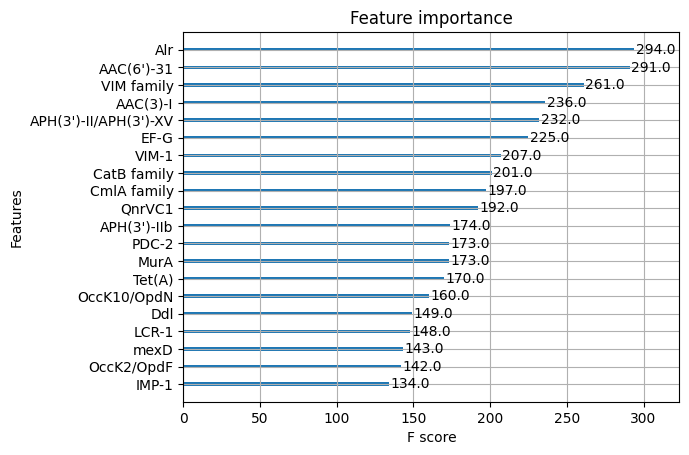

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and train
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
# Calculate metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)  # Or use mean_squared_error(..., squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")



xgb.plot_importance(xgb_model, max_num_features=20)  # Top 20 important features

Epoch 0, Loss: 25119.1172
Epoch 10, Loss: 24384.0449
Epoch 20, Loss: 21960.5391
Epoch 30, Loss: 17284.0742
Epoch 40, Loss: 13758.6680
Epoch 50, Loss: 11978.4131
Epoch 60, Loss: 10518.9121
Epoch 70, Loss: 9201.7109
Epoch 80, Loss: 8165.3833
Epoch 90, Loss: 7332.8887
Epoch 100, Loss: 6605.8467
Epoch 110, Loss: 5926.8950
Epoch 120, Loss: 5421.7920
Epoch 130, Loss: 4936.9292
Epoch 140, Loss: 4417.3413


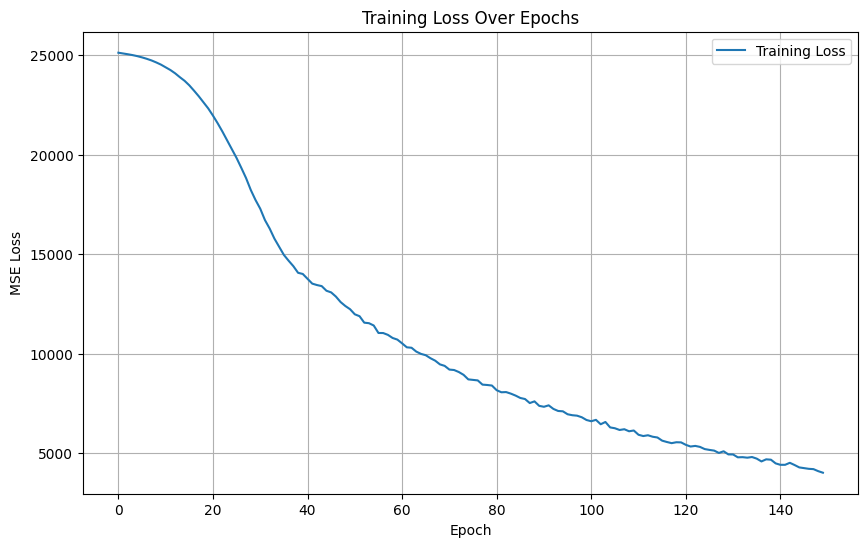


Evaluation Metrics:
- MSE: 39254.6906
- RMSE: 198.1280
- R²: -0.9372


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Neural Network Definition
class NNRegressor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize
input_size = X_train_scaled.shape[1]
model = NNRegressor(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)

# Training loop with loss tracking
epochs = 150
train_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot epoch vs loss
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).numpy().flatten()

mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("\nEvaluation Metrics:")
print(f"- MSE: {mse_nn:.4f}")
print(f"- RMSE: {rmse_nn:.4f}")
print(f"- R²: {r2_nn:.4f}")

In [ ]:
model

NNRegressor(
  (layers): Sequential(
    (0): Linear(in_features=668, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

# Plotting works



In [ ]:
final_df

,GenomeID,AAC(6')-Ia (and related AACs),AAC(6')-Ib/AAC(6')-II,AAC(6')-Ie-APH(2'')-Ia,AAC(6')-Ip,ANT(4')-Ib,ANT(6)-I,ANT(6)-Ia,ANT(6)-Ib,ANT(9)-I,...,yvqE,yvqF,yxjB,yyaP_1,yycF,Genome ID,Antibiotic,Measurement Value,Measurement Unit,Laboratory Typing Method
0,1302.575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1302.575,clindamycin,0.120,mg/L,Broth dilution
1,1302.575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1302.575,tigecycline,0.015,mg/L,Broth dilution
2,1302.575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1302.575,azithromycin,0.250,mg/L,Broth dilution
3,1302.575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1302.575,meropenem,0.250,mg/L,Broth dilution
4,1302.575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1302.575,vancomycin,1.000,mg/L,Broth dilution
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95896,1334.366,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1334.366,sulfamethoxazole,9.500,mg/L,Broth dilution
95897,1334.367,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1334.367,sulfamethoxazole,9.500,mg/L,Broth dilution
95898,1334.367,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1334.367,clavulanic acid,1.000,mg/L,Broth dilution
95899,28037.1948,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,28037.1948,clavulanic acid,1.000,mg/L,Broth dilution


<ipython-input-38-e0dc2cda0702>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=final_df,


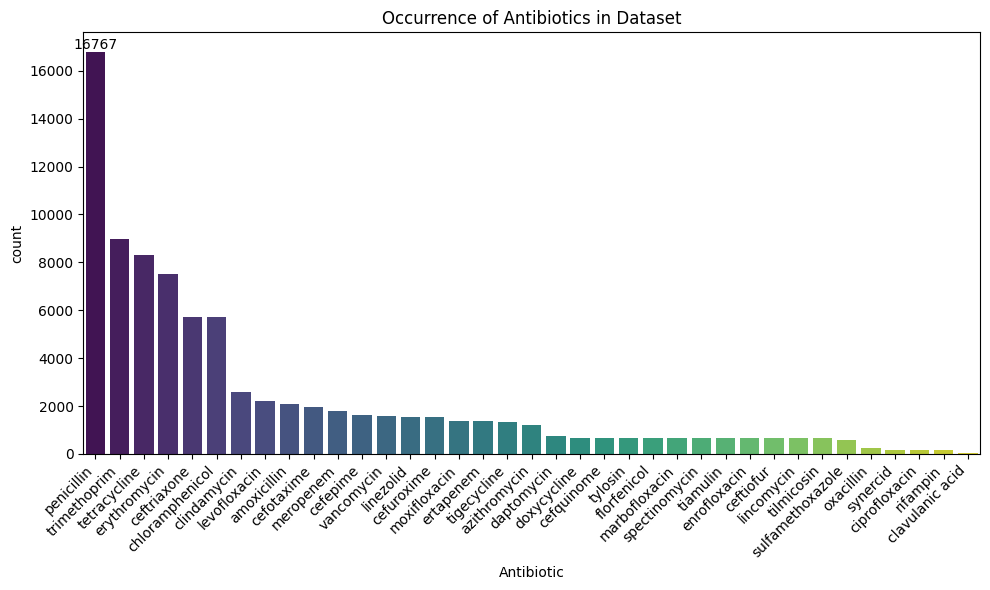

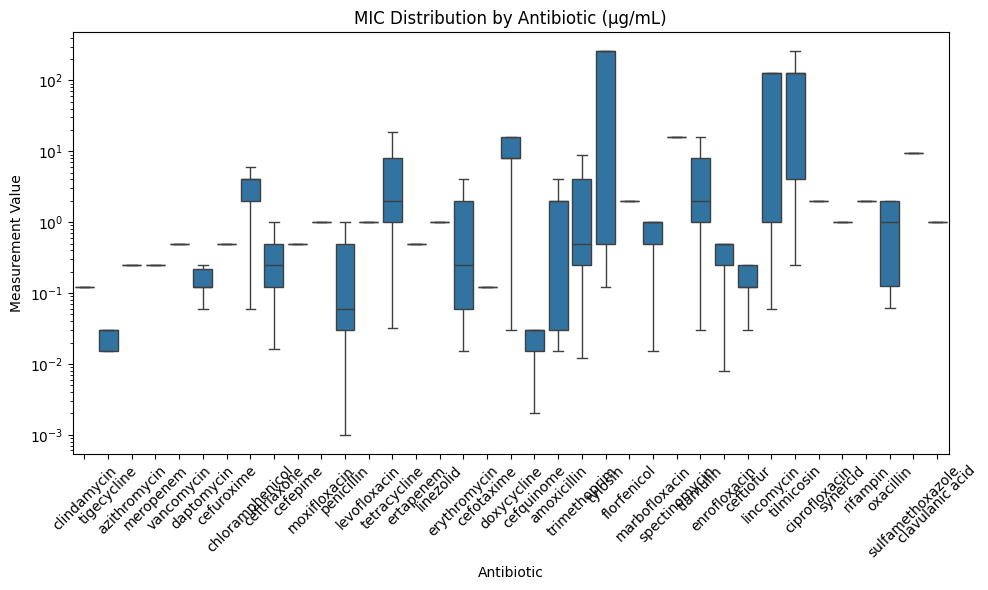

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Countplot for Antibiotic Frequencies
plt.figure(figsize=(10,6))
ax = sns.countplot(data=final_df,
                   x='Antibiotic',
                   order=final_df['Antibiotic'].value_counts().index,
                   palette='viridis')
plt.title('Occurrence of Antibiotics in Dataset')
plt.xticks(rotation=45, ha='right')
ax.bar_label(ax.containers[0])  # Add counts on bars
plt.tight_layout()
plt.show()

# 2. MIC Distribution (Boxplot)
plt.figure(figsize=(10,6))
sns.boxplot(data=final_df,
            x='Antibiotic',
            y='Measurement Value',
            showfliers=False)
plt.title('MIC Distribution by Antibiotic (μg/mL)')
plt.xticks(rotation=45)
plt.yscale('log')  # Log-scale for better visualization
plt.tight_layout()

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


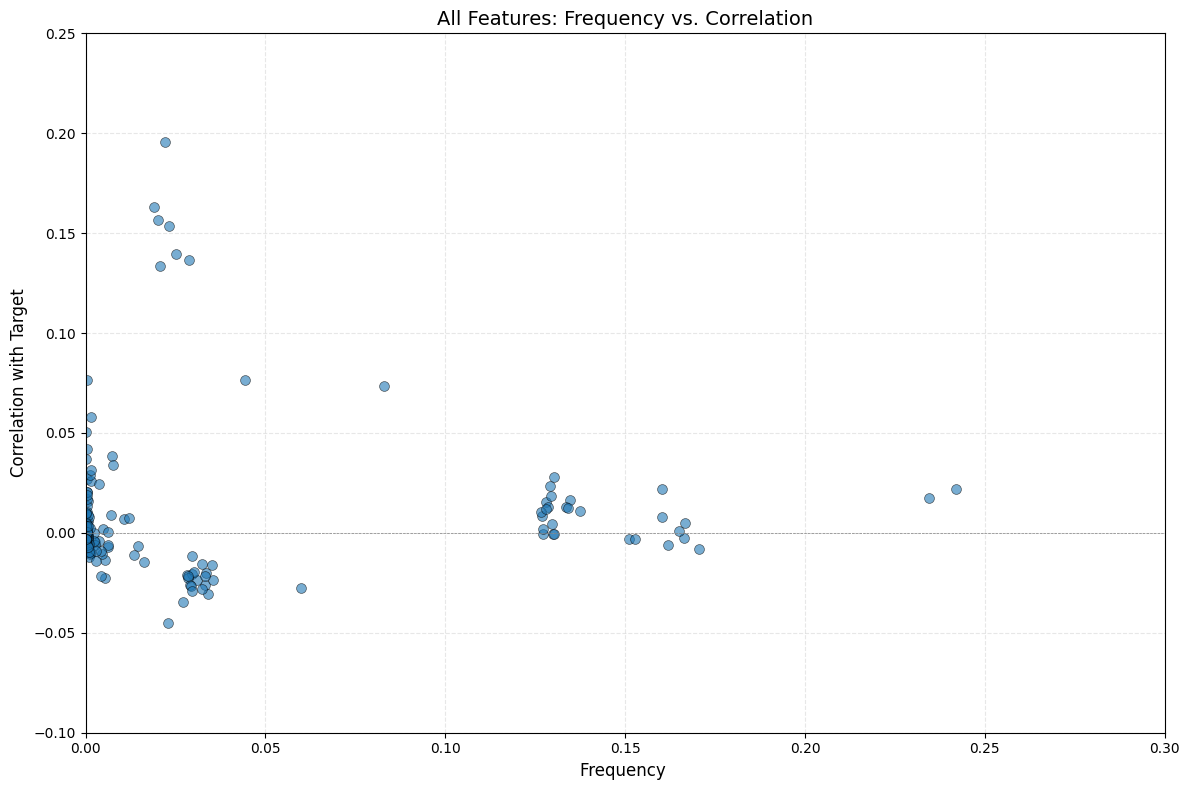

In [ ]:
# i am taking ciprofloxacin and plotting the freq of genes and correlation
df = final_df[final_df["Antibiotic"]=="penicillin"]
feature_freq = df.drop(columns=["GenomeID", "Genome ID", "Antibiotic","Measurement Unit","Measurement Value", "Laboratory Typing Method"]).mean()  # Frequency of each feature
feature_corr = df.drop(columns=["GenomeID", "Genome ID", "Antibiotic","Measurement Unit","Measurement Value", "Laboratory Typing Method"]).corrwith(df["Measurement Value"])

import pandas as pd
corr_freq_df = pd.DataFrame({
    'Feature': feature_freq.index,
    'Frequency': feature_freq.values,
    'Correlation': feature_corr.values
})

# Set up the plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=corr_freq_df,
    x='Frequency',
    y='Correlation',
    alpha=0.6,  # Transparency to handle overlaps
    s=50,       # Marker size
    edgecolor='k',
    linewidth=0.5
)

# Set axis limits and labels
plt.xlim(0, 0.3)
plt.ylim(-0.1, 0.25)  # Allow for negative correlations
plt.title('All Features: Frequency vs. Correlation', fontsize=14)
plt.xlabel('Frequency ', fontsize=12)
plt.ylabel('Correlation with Target', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)


# Highlight quadrants (optional)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)  # Zero correlation line
plt.axvline(0.5, color='grey', linestyle='--', linewidth=0.5)  # Median frequency

plt.tight_layout()
plt.show()

In [ ]:
df

,GenomeID,AAC(6')-Ia (and related AACs),AAC(6')-Ib/AAC(6')-II,AAC(6')-Ie-APH(2'')-Ia,AAC(6')-Ip,ANT(4')-Ib,ANT(6)-I,ANT(6)-Ia,ANT(6)-Ib,ANT(9)-I,...,yvqE,yvqF,yxjB,yyaP_1,yycF,Genome ID,Antibiotic,Measurement Value,Measurement Unit,Laboratory Typing Method
11,1302.575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1302.575,penicillin,0.03,mg/L,Broth dilution
19,1303.1204,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1303.1204,penicillin,0.25,mg/L,Broth dilution
50,1306.201,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1306.201,penicillin,0.06,mg/L,Broth dilution
64,1307.7503,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1307.7503,penicillin,0.03,mg/L,MIC
79,1307.7504,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1307.7504,penicillin,0.03,mg/L,MIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77285,1334.364,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1334.364,penicillin,0.03,mg/L,Broth dilution
77309,1334.365,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1334.365,penicillin,0.03,mg/L,Broth dilution
77327,1334.366,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1334.366,penicillin,0.03,mg/L,Broth dilution
77345,1334.367,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1334.367,penicillin,0.03,mg/L,Broth dilution


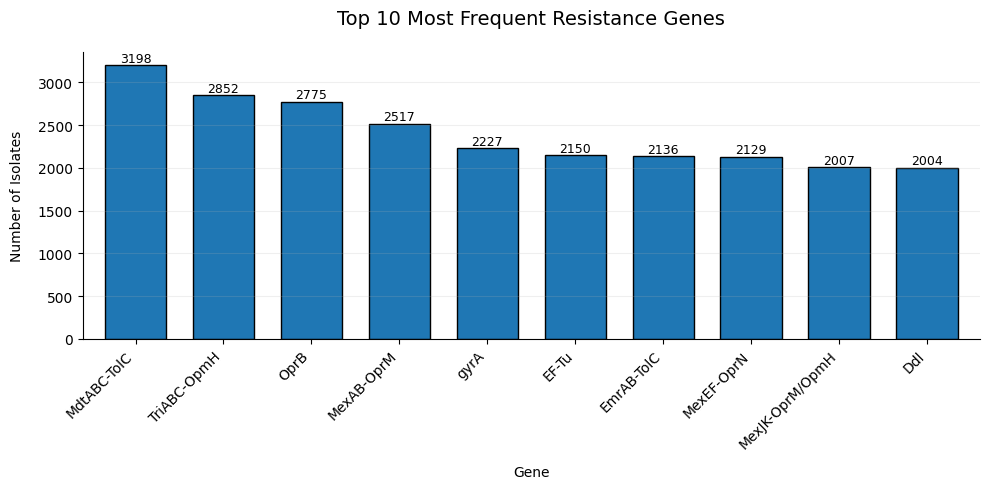

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-gene columns
d1 = final_df.drop(columns=["GenomeID", "Genome ID", "Antibiotic","Measurement Unit","Measurement Value", "Laboratory Typing Method"])

# Sum gene occurrences and get top 10
gene_counts = d1.sum().sort_values(ascending=False).head(10)

# Plot with improved styling
plt.figure(figsize=(10, 5))
ax = gene_counts.plot(kind='bar',
                     color='#1f77b4',
                     edgecolor='black',
                     width=0.7)

# Customize plot
plt.title('Top 10 Most Frequent Resistance Genes', pad=20, fontsize=14)
plt.ylabel('Number of Isolates', labelpad=10)
plt.xlabel('Gene', labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=9)

plt.grid(axis='y', alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
final_df

,GenomeID,AAC(2')-I,AAC(3)-I,"AAC(3)-II,III,IV,VI,VIII,IX,X",AAC(3)-IIa,AAC(3)-IIc,AAC(3)-IV,AAC(3)-Id,AAC(3)-VIa,AAC(6')-IIc,...,yojI,yojI_1,yojI_2,yusO,yycF,Genome ID,Antibiotic,Measurement Value,Measurement Unit,Laboratory Typing Method
0,1079901.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1079901.3,gentamicin,0.500,mg/L,Broth dilution
1,1079901.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1079901.3,ciprofloxacin,0.015,mg/L,Broth dilution
2,1079901.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1079901.3,cefoxitin,4.000,mg/L,Broth dilution
3,1079901.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1079901.3,ceftriaxone,8.000,mg/L,Broth dilution
4,1079901.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1079901.3,streptomycin,32.000,mg/L,Broth dilution
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60042,90371.3119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,90371.3119,sulfamethoxazole,19.000,mg/L,Broth dilution
60043,90371.3695,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,90371.3695,sulfamethoxazole,4.750,mg/L,Broth dilution
60044,90371.3696,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,90371.3696,sulfamethoxazole,2.370,mg/L,Broth dilution
60524,98360.273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,98360.273,sulfamethoxazole,4.750,mg/L,Broth dilution
